## Counting Bigrams Vs Gradient Based Optimization

In this project we will use a data set of names and then use two different approaches to create more similar names. The two models we will use are namely:
Counting Bigrams and Single Layer Neural Network. We will utilize the pytorch framework to make our code consise and then we will compare the two models. We will also compare how regularizations is used in both the models in two different ways.


# 1) Bigram Counting Model

1.1) Counting Model: In this model we count the no of bigrams (two characters) occurances and arrange it into a 27 x 27 grid. There is one especial character "." which will be used to denote startin and ending of a name. The grid is then summed up and normalized to create a probability distribution. We then sample characters from this distribution to create new names :)

# 1.2) Mount the Google Drive & Load our Data Set.

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/MachineLearningProjects /names.txt'

# Lets see what is in our data set
with open(file_path, 'r') as file:
  content = file.read()
  words = content.splitlines()
  # splitlines() splits the data into indivisual names and stores in a lsit.
  # It is simialr to split('\n\) but is more versatile and recognizes other new
  # line character

print(words[:5])

Mounted at /content/drive
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [ ]:
# Lets print some information about our data set

print(f"The total number of names in our data set is {len(words)}")
print(f"The minimum length of word is {min(len(word) for word in words)}")
print(f"The maximum length of word is {max(len(word) for word in words)}")




The total number of names in our data set is 32033
The minimum length of word is 2
The maximum length of word is 15


# 1.3) Create the 27 x 27 count Matrix

In [ ]:
import torch

# Data type by default is float. Change it to int for counting

N = torch.zeros((27, 27), dtype=torch.int32) # creates a 27x27 matrix of zeros

# Lets create a lookup table from characters to index and vice versa

chars = sorted(list(set(''.join(words)))) # return a sorted list of all characters
stoi = {s:i+1 for i,s in enumerate(chars)} # string to index mapping
stoi['.'] = 0 # The special character is at index 0
itos = {i:s for s,i in stoi.items()} # index to string mapping

# Now we count the number of bigram occurance

for w in words:
  chs = ['.'] + list(w) + ['.'] # this returns a list with "." at the start and end.
  for ch1, ch2 in zip(chs, chs[1:]): # zip returns a iterable of tuples
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1 # Counting the occurance




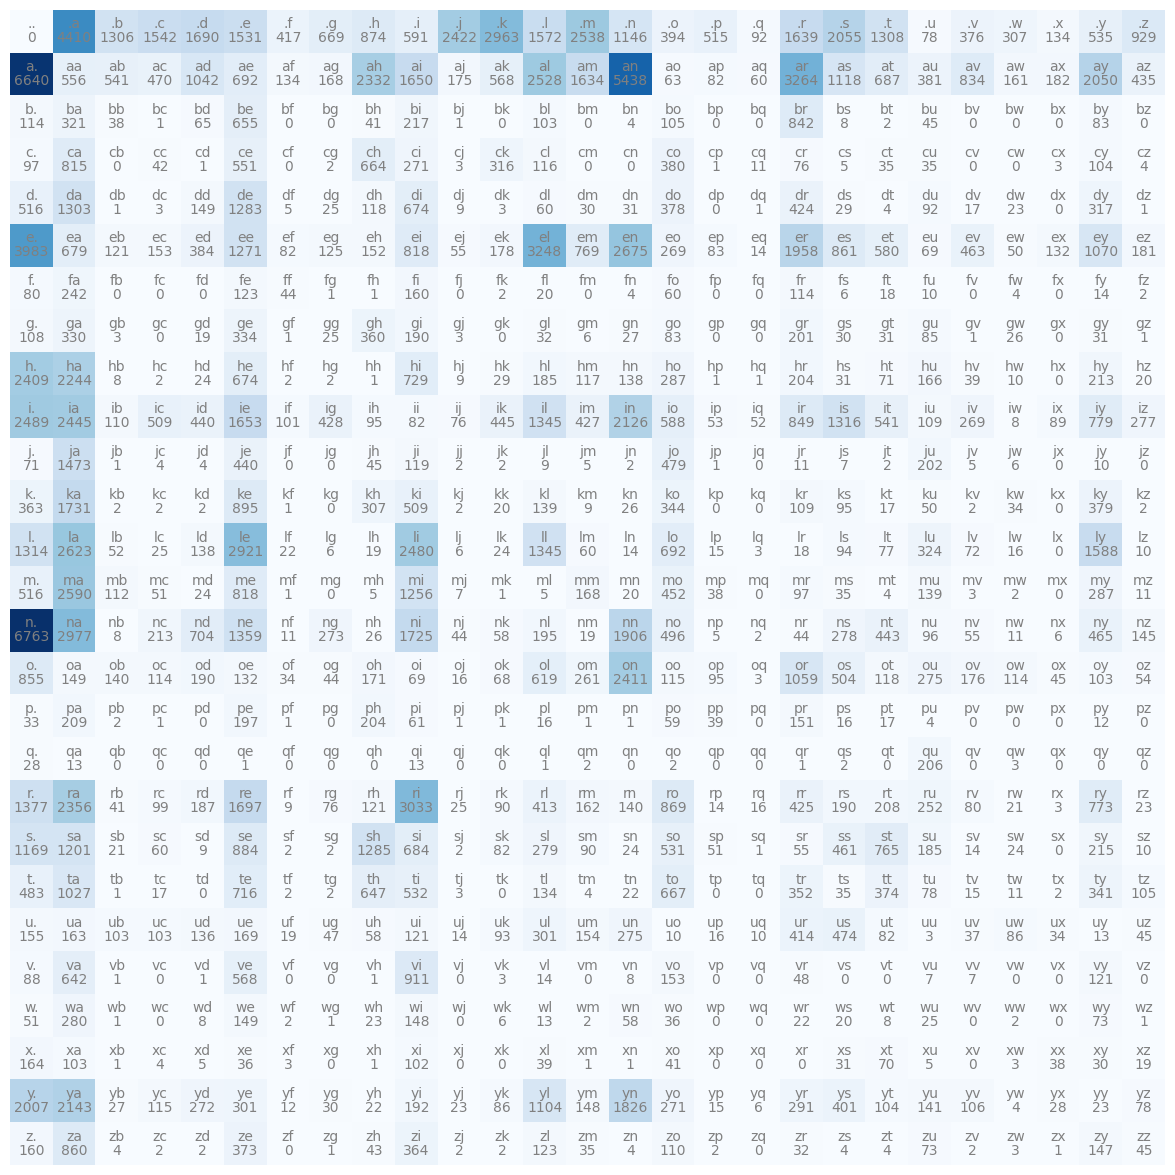

In [ ]:
# Lets visualize our count matrix N

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,15))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

# 1.4) Sample names form the grid

# 1.4a) Naive Approach to Sampling

We will use torch.multinomial to sample characters from our grid. Torch.multinomial can be used to get a integer provided a probability distribution. We will also use a generator to make our results deterministic menaing if you run this code on your computer you will get the same results.
We will first normalize the first row and sample from it. Then we will use this probability distribution along with torch.multinomial to sample characters.<br>
This approach is naive (or not optimized for tensor operation) because of the first two lines in the while loop. We convert the grid into float and normalize it everytime we are in the loop. This is not a good practice especially when one is dealing with more complicated models. 1.4b fixes this.

In [25]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5): # Sample 10 names
  out = []
  ix = 0
  while True:
    p = N[ix].float() # Convert the row to float
    p = p / p.sum() # Normalize the row
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0: # If the last character is "."
      break
  print("How about the name:", ''.join(out)) # Join the characters to create a word


How about the name: junide.
How about the name: janasah.
How about the name: p.
How about the name: cony.
How about the name: a.


# 1.4b) Optimzed Approach

In this approach we will compute a matrix ahead of the while loop which will contain all the probabilities. This way we do not have to create probabilites everytime we enter the loop. We will make use of tensor broadcasting rules.

In [24]:
g = torch.Generator().manual_seed(2147483647)
P = N.float()
P /= P.sum(1, keepdim=True)

for i in range(5): # Sample 10 names
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0: # If the last character is "."
      break
  print("How about the name:",''.join(out)) # Join the characters to create a word

# The argument "1" in sum means that we want to sum along the rows and not columns.
# keepdim=True ensure the size is 27x1 column vector
# We can divide P/P.sum(1, keepdim=True) becasue it broadcastible acording to the
# rules. P is a 27x27 and P.sum(1, keepdim=True) is 27x1 but when we divide the
# 27x1 column vector is stretched to 27x27 in which the columns are copied 27 times
# to make a 27x27 tensor.



How about the name: junide.
How about the name: janasah.
How about the name: p.
How about the name: cony.
How about the name: a.


# Counting Model Conclusion
The counting model provides us words that are somewhat name like for example "Junide" and some of the names are just terrible like "a.". The couting bigram model is simple but is not very effective or impressive.

# 2) Gradient Base Approach

Now we will use a single layer neural network model and optimize the weight matrix using gradient descent. We will use one hot encoding to embed the data as NN can only take in numbers. We will use a negative log likelihood loss function to train our model.

In [ ]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [ ]:
log_likelihood = 0.0
n = 0

for w in words:
#for w in ["andrejq"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


In [ ]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
xenc.shape

torch.Size([5, 27])

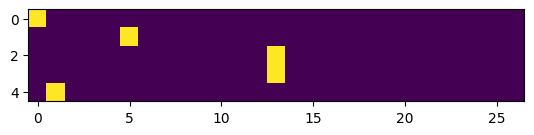

In [ ]:
plt.imshow(xenc)

In [ ]:
xenc.dtype

torch.float32

In [ ]:
W = torch.randn((27, 1))
xenc @ W

tensor([[-0.6886],
        [-0.6239],
        [ 0.3903],
        [ 0.3903],
        [ 0.6031]])

In [ ]:
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [ ]:
probs[0]

tensor([1.])

In [ ]:
probs[0].shape

torch.Size([1])

In [ ]:
probs[0].sum()

tensor(1.)

In [ ]:
# (5, 27) @ (27, 27) -> (5, 27)

In [ ]:
# SUMMARY ------------------------------>>>>

In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [ ]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [ ]:
probs.shape

torch.Size([5, 27])

In [ ]:

nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.

In [ ]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [ ]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
print(loss.item())

3.7693049907684326


In [ ]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [ ]:
W.data += -0.1 * W.grad

In [ ]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [ ]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [ ]:
# gradient descent
for k in range(1):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

3.7686190605163574


In [ ]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:

    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

juwjdjdjancqydjufhqyywecnw.
.
oiin.
toziasz.
twt.
